In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['export OPENBLAS_NUM_THREADS']='2'

In [2]:
import torch
import torch.nn as nn

import numpy as np
from scipy.io import loadmat, savemat
import math
import os
import h5py
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
from functools import partial
from models.models import MWT1d
from models.utils import train, test, LpLoss, get_filter, UnitGaussianNormalizer

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def get_initializer(name):
    
    if name == 'xavier_normal':
        init_ = partial(nn.init.xavier_normal_)
    elif name == 'kaiming_uniform':
        init_ = partial(nn.init.kaiming_uniform_)
    elif name == 'kaiming_normal':
        init_ = partial(nn.init.kaiming_normal_)
    return init_

In [7]:
def makeVid(tensor, set, dirPath):
    
    newDir = 'train{}'.format(set)
    path = os.path.join(dirPath, newDir)
    if os.path.isdir(path):
        pass
    else:
        os.mkdir(path)
    
    for i in range(tensor.shape[-1]):
        f = tensor[set][:, :, i]
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(f, interpolation='nearest')
        cbar = fig.colorbar(cax)
        
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        cbar.set_label('Vorticity (RPM)', rotation=270)
        ax.set_title('Two-dimensional Vorticity')
        plt.savefig(path+'/{}.png'.format(i))
    
    img_array = []
    filelist = glob.glob(path+'/*.png')
    
    for filename in sorted(filelist):
        img = cv2.imread(filename)
        print(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
    
    fps = 1
    vids = os.path.join(dirPath, 'videos')
    if os.path.isdir(vids):
        pass
    else:
        os.mkdir(vids)

    vidpath = vids+'/Vid{}.mp4'.format(set)
    out = cv2.VideoWriter(vidpath ,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

    for j in range(len(img_array)):
        out.write(img_array[j])
    out.release()

In [8]:
ntrain = 1000
ntest = 200

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h
batch_size = 20

rw_ = loadmat('Data/kDV/kdv_train_test.mat')
x_data = rw_['input'].astype(np.float32)
y_data = rw_['output'].astype(np.float32)

In [9]:
x_train = x_data[:ntrain,::sub]
y_train = y_data[:ntrain,::sub]
x_test = x_data[-ntest:,::sub]
y_test = y_data[-ntest:,::sub]

x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

x_train = x_train.unsqueeze(-1)
x_test = x_test.unsqueeze(-1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [10]:
ich = 1
initializer = get_initializer('xavier_normal') # xavier_normal, kaiming_normal, kaiming_uniform

model = MWT1d(ich,
            alpha = 10,
            c = 4*4,
            k = 4,
            base = 'legendre', # chebyshev
            nCZ = 2,
            initializer = initializer,
            ).to(device)
learning_rate = 0.001

epochs = 250
step_size = 100
gamma = 0.5

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)

In [12]:
PATH = 'kdv_models/kdv_model250.pt'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

MWT1d(
  (Lk): Linear(in_features=1, out_features=64, bias=True)
  (MWT_CZ): ModuleList(
    (0): MWT_CZ1d(
      (A): sparseKernelFT1d()
      (B): sparseKernelFT1d()
      (C): sparseKernelFT1d()
      (T0): Linear(in_features=4, out_features=4, bias=True)
    )
    (1): MWT_CZ1d(
      (A): sparseKernelFT1d()
      (B): sparseKernelFT1d()
      (C): sparseKernelFT1d()
      (T0): Linear(in_features=4, out_features=4, bias=True)
    )
  )
  (Lc0): Linear(in_features=64, out_features=128, bias=True)
  (Lc1): Linear(in_features=128, out_features=1, bias=True)
)

In [13]:
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

0 0.005083795171231031
1 0.006797910667955875
2 0.004504068288952112
3 0.010359400883316994
4 0.004034196957945824
5 0.004556821659207344
6 0.0028828249778598547
7 0.0036152047105133533
8 0.003537829965353012
9 0.0042583090253174305
10 0.006233173422515392
11 0.015627343207597733
12 0.003215022385120392
13 0.00315837818197906
14 0.0029326421208679676
15 0.00397823192179203
16 0.0059278798289597034
17 0.003118332242593169
18 0.005664420779794455
19 0.005582057870924473
20 0.005533767864108086
21 0.0034296964295208454
22 0.005741196218878031
23 0.009492866694927216
24 0.002863652305677533
25 0.0028140260837972164
26 0.004500978626310825
27 0.0033495251554995775
28 0.005021268036216497
29 0.0028446789365261793
30 0.003724135458469391
31 0.003109770594164729
32 0.0038187180180102587
33 0.004604568239301443
34 0.004274218343198299
35 0.004299108404666185
36 0.003947431221604347
37 0.006917276885360479
38 0.005780471954494715
39 0.0044527738355100155
40 0.003130908589810133
41 0.003425275906

In [14]:
index = 0
for x, y in test_loader:

    # Shapes is 1024 inputs (x) and 1024 outputs (y)
    # print(x[0].shape)
    # print(y[0].shape)

    # Create plots with pre-defined labels.    
    fig, ax = plt.subplots()
    fig.set_figwidth(11)
    fig.set_figheight(7)
    ax.plot(x[0], label='Initial evolution $u(x,t)$ where $t \in$ [0,1024]')
    ax.plot(pred[index], label='Predicted evolution $(t \in [1025,2048])$')
    ax.plot(y[0], 'k--', label='Real evolution $(t \in [1025,2048])$')
    index += 1
    legend = ax.legend(loc='lower right', shadow=True)
    ax.set_xlabel("Initial condition index")
    ax.set_ylabel("Initial condition value u(x,t)")
    ax.set_title("Time evolution of initial conditions")
    ax.grid()
    
    # Put a nicer background color on the legend.
    # legend.get_frame().set_facecolor('C0')
    plt.savefig('animations/kdv/train250/fig{}.png'.format(index))
    # files.download("/content/drive/MyDrive/IIB project/mwt/ip-op/fig{}.png".format(index)) 
    plt.clf()
    plt.show()

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

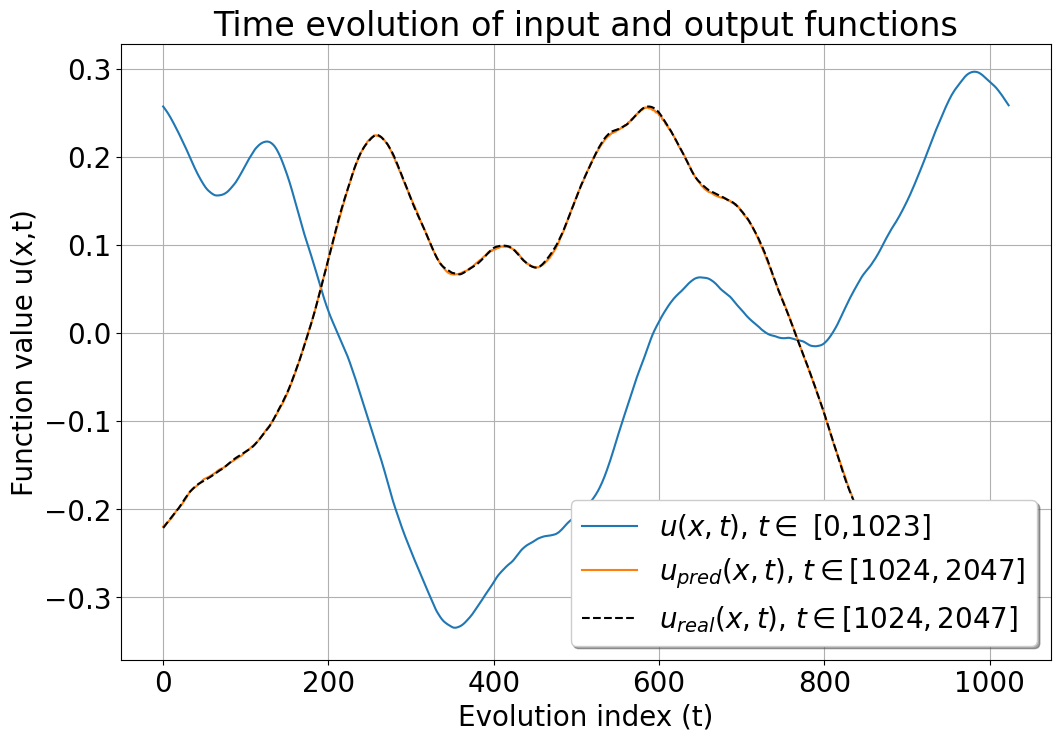

In [15]:
# Create plots with pre-defined labels.    
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
ax.plot(x[0], label='$u(x,t)$, $t \in$ [0,1023]')
ax.plot(pred[199], label='$u_{pred}(x,t)$, $t \in [1024,2047]$')
ax.plot(y[0], 'k--', label='$u_{real}(x,t)$, $t \in [1024,2047]$')
index += 1
legend = ax.legend(loc='lower right', shadow=True)
ax.set_xlabel("Evolution index (t)")
ax.set_ylabel("Function value u(x,t)")
ax.set_title("Time evolution of input and output functions")
ax.grid()